In [34]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from IPython.display import Image, display
from pandas.tools.plotting import scatter_matrix 
%matplotlib inline


#import category_encoders as ce
import warnings; warnings.simplefilter('ignore')

The total size of the training dataset is ~24GB so let's load it in small chunks and perform data cleanup. 

Some of the columns are in JSON format, we need to convert all the json fields in the file to a flattened csv format and create a dataframe without overshooting the available memory. 

In [4]:
raw_data16 = pd.DataFrame()
raw_data17 = pd.DataFrame()
raw_data18 = pd.DataFrame()
chunksize = 5000
counter = 0
csv_path = ".\\..\\all\\train_v2.csv"

JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

chunt_itr = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     chunksize=chunksize)

for chunk in chunt_itr:
    process(chunk)
print('done chunking')

done chunking


In [3]:
# Process each chunk to filter data for only 2016 and append to a dataframe
def process(chunk):
    global raw_data16
    global raw_data17 
    global raw_data18 
    filtered_chunk = chunk[(chunk.date > 20160000) & (chunk.date < 20170000)]
    raw_data16 = raw_data16.append(filtered_chunk, ignore_index=True)
    del filtered_chunk
    filtered_chunk17 = chunk[(chunk.date > 20170000) & (chunk.date < 20180000)]
    raw_data17 = raw_data17.append(filtered_chunk17, ignore_index=True)
    del filtered_chunk17
    filtered_chunk18 = chunk[(chunk.date > 20180000)]
    raw_data18 = raw_data18.append(filtered_chunk18, ignore_index=True)
    del filtered_chunk18

In [5]:
for column in JSON_COLUMNS:
    column_as_df = json_normalize(raw_data16[column])
    column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
    raw_data16 = raw_data16.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    
for column in JSON_COLUMNS:
    column_as_df = json_normalize(raw_data17[column])
    column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
    raw_data17 = raw_data17.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    
for column in JSON_COLUMNS:
    column_as_df = json_normalize(raw_data18[column])
    column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
    raw_data18 = raw_data18.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

Columns with constant values:

Looks like there are quite a few features with constant value in the train set. Let us get the list of these features. Columns with constant and null values do not help us with the prediction.

In [6]:
const_cols16 = [c for c in raw_data16.columns if raw_data16[c].nunique(dropna=False)==1 ]

In [7]:
const_cols17 = [c for c in raw_data17.columns if raw_data17[c].nunique(dropna=False)==1 ]

In [8]:
const_cols18 = [c for c in raw_data18.columns if raw_data18[c].nunique(dropna=False)==1 ]

In [32]:
const_cols = const_cols18 and const_cols17 and const_cols16
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [33]:
cols_to_drop = const_cols
print("before:", raw_data16.shape)
train_df16 = raw_data16.drop(cols_to_drop  + ["trafficSource.campaignCode"], axis=1)
train_df16["totals.sessionQualityDim"] = np.nan
train_df16 = train_df16.sort_index(axis=1)
print("after:", train_df16.shape)

before: (436393, 59)
after: (436393, 40)


In [11]:
#cols_to_drop = const_cols
print("before:", raw_data17.shape)
train_df17 = raw_data17.drop(cols_to_drop, axis=1)
print("after:", train_df17.shape)

before: (928860, 59)
after: (928860, 40)


In [35]:
print("before:", raw_data18.shape)
train_df18 = raw_data18.drop(cols_to_drop, axis=1)
print("after:", train_df18.shape)

before: (343084, 59)
after: (343084, 40)


In [36]:
frames = [train_df16, train_df17, train_df18]
train_df = pd.concat(frames)
print(train_df.head())

  channelGrouping                            customDimensions      date  \
0  Organic Search           [{'index': '4', 'value': 'EMEA'}]  20160902   
1  Organic Search  [{'index': '4', 'value': 'South America'}]  20160902   
2  Organic Search           [{'index': '4', 'value': 'APAC'}]  20160902   
3  Organic Search           [{'index': '4', 'value': 'APAC'}]  20160902   
4  Organic Search  [{'index': '4', 'value': 'South America'}]  20160902   

  device.browser device.deviceCategory  device.isMobile  \
0        Firefox               desktop            False   
1         Chrome               desktop            False   
2         Chrome               desktop            False   
3         Safari                mobile             True   
4         Chrome               desktop            False   

  device.operatingSystem        fullVisitorId                geoNetwork.city  \
0                Windows  9499785259412240342  not available in demo dataset   
1                Windows  36969065

<BarContainer object of 40 artists>

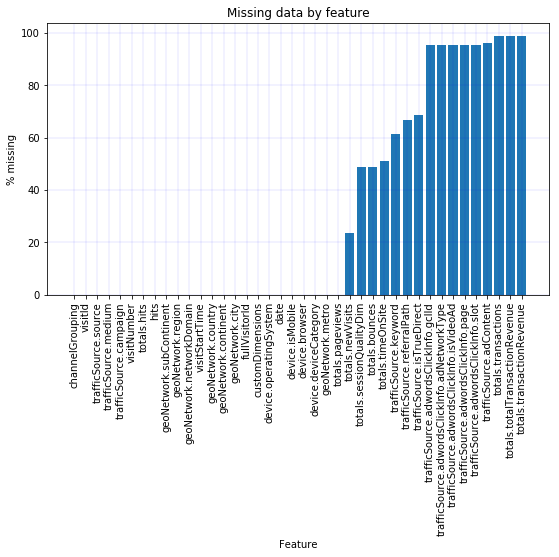

In [14]:
percent_missing = train_df.isna().sum() * 100 / len(train_df)
columns = train_df.columns.values
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
fig,ax = plt.subplots(1,1,figsize=(9,5))
ax.set_title("Missing data by feature")
ax.set_ylabel("% missing")
ax.set_xlabel("Feature")
plt.xticks(rotation=90)
ax.grid(color='b', linestyle='-', linewidth=0.1)
ax.bar(missing_value_df.column_name, missing_value_df.percent_missing)

In [15]:
train_df["totals.transactionRevenue"].fillna(0, inplace=True)

In [18]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

#Plot the distribution

#plt.figure(figsize=(8,6))
#plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
#plt.xlabel('index', fontsize=12)
#plt.ylabel('TransactionRevenue', fontsize=12)
#plt.show()

nzi = (train_df["totals.transactionRevenue"]>0).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  18514  and ratio is :  0.010837440153786987
Number of unique customers with non-zero revenue :  16141 and the ratio is :  0.012193574218307359


In [19]:
train_df.head()
print(train_df.shape)

(1708337, 40)


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1708337 entries, 0 to 343083
Data columns (total 40 columns):
channelGrouping                                 object
customDimensions                                object
date                                            int64
device.browser                                  object
device.deviceCategory                           object
device.isMobile                                 bool
device.operatingSystem                          object
fullVisitorId                                   object
geoNetwork.city                                 object
geoNetwork.continent                            object
geoNetwork.country                              object
geoNetwork.metro                                object
geoNetwork.networkDomain                        object
geoNetwork.region                               object
geoNetwork.subContinent                         object
hits                                            object
totals.boun

Some columns do not have the right data type selected for them, let's fix this:

In [37]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)

Columns customDimensions and hits do not seem to add a lot of information, let's ignore them for now and we can come back to this later

In [38]:
train_df.drop(['customDimensions'], axis=1, inplace=True)

In [24]:
train_df.head()

,channelGrouping,date,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.continent,geoNetwork.country,...,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,Firefox,desktop,False,Windows,9499785259412240342,not available in demo dataset,Europe,Netherlands,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1472812272,1.0,1.472812e+09
1,Organic Search,20160902,Chrome,desktop,False,Windows,3696906537737368442,Buenos Aires,Americas,Argentina,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1472856874,1.0,1.472857e+09
2,Organic Search,20160902,Chrome,desktop,False,Linux,5688512451361930466,Bengaluru,Asia,India,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1472811524,1.0,1.472812e+09
3,Organic Search,20160902,Safari,mobile,True,iOS,9716453263501147451,New Delhi,Asia,India,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1472823508,1.0,1.472824e+09
4,Organic Search,20160902,Chrome,desktop,False,Windows,5330453591145100432,Sao Paulo,Americas,Brazil,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1472839619,1.0,1.472840e+09


In [25]:
train_df.drop(['hits'], axis=1, inplace=True)

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1708337 entries, 0 to 343083
Data columns (total 38 columns):
channelGrouping                                 object
date                                            int64
device.browser                                  object
device.deviceCategory                           object
device.isMobile                                 bool
device.operatingSystem                          object
fullVisitorId                                   object
geoNetwork.city                                 object
geoNetwork.continent                            object
geoNetwork.country                              object
geoNetwork.metro                                object
geoNetwork.networkDomain                        object
geoNetwork.region                               object
geoNetwork.subContinent                         object
totals.bounces                                  float64
totals.hits                                     float64
totals.ne

### Save the file

In [27]:
train_df.to_csv("train.csv", index=False)